In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys, os
sys.path.append('C:\\Users\Quentin\\Documents\\ALMA_CHILI\\gaia-shock\\src')

## directory
rootdir = r'C:\Users\Quentin\Documents\ALMA_CHILI'
wdir    = r'%s\products'%(rootdir)
#notedir = r'%s\gaia-shock\notebooks_Quentin'%(rootdir)

os.chdir(wdir)  # to change the current directory
import gaia_utils_quentin as gu

with open('ilabel_dbscan', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    file_result = my_depickler.load()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
clustername = "NGC2516"
RADIUS       = 3.
errtol       = 0.10

source = gu.source(clustername, RADIUS, errtol)
source.read_votable()
source.convert_filter_data()
ilabel = file_result[clustername]['ilabel']

## NGC2516-3.0deg-0.1err.vot read...
## Total stars: 79407

## Conversion done...
## Stars selected: 66786


mean Dist: 415.1


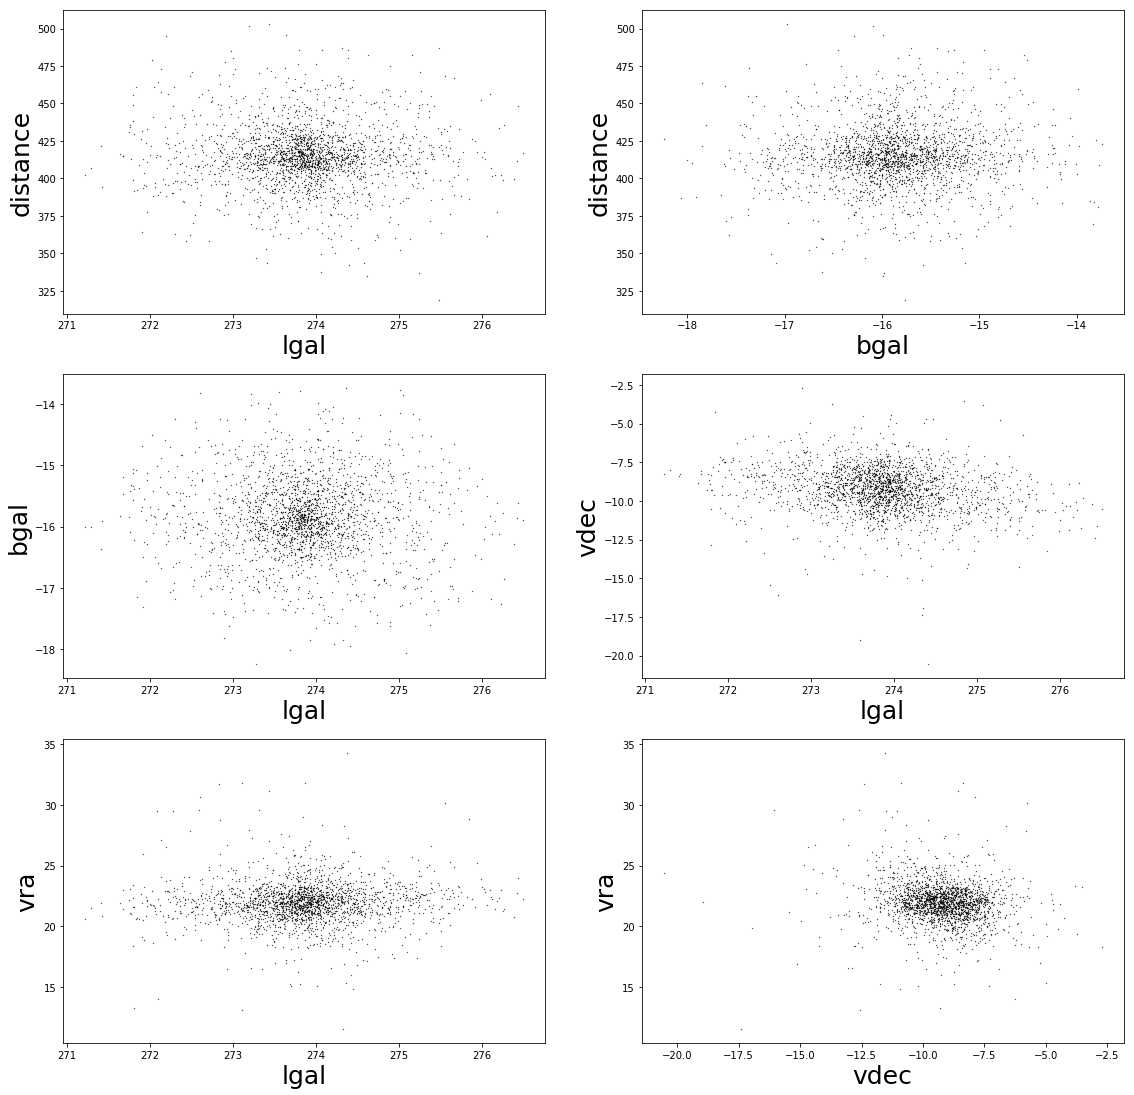

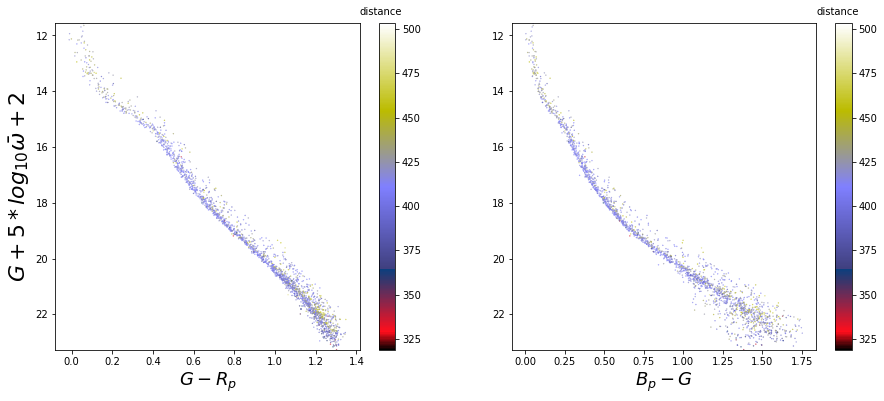

In [7]:
print("mean Dist: %5.1f"%np.mean(source.df[ilabel,0]))
gu.plot_information_cluster(source.df[ilabel,:], 0.1, False)